<img src="logo_UCLA_blue_boxed.svg" alt="ucla logo" width="150" align="left"/>

### **MAE 150A - Intermediate Fluid Mechanics**

<hr />

# Boundary layer in the Navier-Stokes solution

In this notebook, we will solve the Navier-Stokes equations for the flow past a stationary flat plate. We will assume that the flow is two-dimensional and incompressible, but we will not make any other assumptions about the flow.

The purpose of this notebook is to see the developing boundary layer and the force on the plate in the full Navier-Stokes environment, and to compare this with our solution of the boundary layer equations.

The main scope of this notebook is a flat plate arranged tangent to the free stream (i.e., we say the plate is at 0 angle of attack). This allows us to look at the boundary layer in the most basic form.

The flow we solve for here is generated by first impulsively starting the fluid from rest. To get the boundary layer, we need to wait until the flow reaches steady state. This means we have to integrate the equations in time until the flow is unchanging.

### First, set up the environment

In [1]:
using MAE150A

┌ Info: Precompiling MAE150A [a017625c-406c-46ee-99d6-0fac6062339e]
└ @ Base loading.jl:1242


In [2]:
pyplot()
initialize_environment()

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v1.2/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1240


### A note on the flow parameters

Note that we will solve this problem with all variables made *dimensionless* by dividing them by the characteristic parameters of the problem. For instance, the $x$ and $y$ coordinates (and all lengths in the problem) are scaled by the length of the plate. That means that we report distance not in units of meters or feet, but instead, in units of "plate lengths", e.g., if the leading edge of the plate is at (0,0), then a point (x,y) = (2,3) is two plate lengths from the leading edge along the x axis and 3 plate lengths above leading edge. In this set of units, the plate's own length is simply equal to 1.

Similarly, the velocities in the problem are scaled by the free stream speed. This allows us to report velocity compared to the free stream, e.g., if u = 1.2, this means the velocity is 1.2 times the free stream speed. In this set of units, the free stream speed itself is simply equal to 1.

Finally, time is scaled by "convective units", plate lengths/free stream velocity. So, e.g., t = 1 in these units represents 1 convective time, or, the time it takes for fluid to pass the plate (or, from a different frame of reference, the time it takes for the plate to travel one length forward).

The Reynolds number is defined from this characteristic length and velocity:

$$ Re = \rho U_\infty L/\mu$$

Note that this is equivalent to $Re_L$ (using the definition of $Re_x$), though this is strictly true if one assumes that $U_e = U_\infty$. This is nearly correct, but there is some subtlety, as we will see below.

#### Set the flow parameters

In [3]:
Re = 500; # Reynolds number based on plate's length
U = 1.0; # Dimensionless free stream velocity
U∞ = (U,0.0);

Set the plate's geometry

In [4]:
n = 51 # number of discrete points along the plate
L = 1.0 # Dimensionless plate length
body = ViscousFlow.Plate(L,n)

Plate with 51 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Transform the body with a specified initial position and orientation.

In [6]:
cent = (0.5,0.0)  # position of the centroid
α = 0.0 # angle of the plate to the x axis
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration

Plate with 51 points and length 1.0 and thickness 0.0
   Current position: (0.5,0.0)
   Current angle (rad): 0.0


### Set up the computational domain and grid spacing

In [7]:
Δx = 0.01 # grid spacing
xlim = (-0.5,4.5)
ylim = (-1.0,1.0)

(-1.0, 1.0)

Plot the body in the flow domain, just to make sure it looks as expected

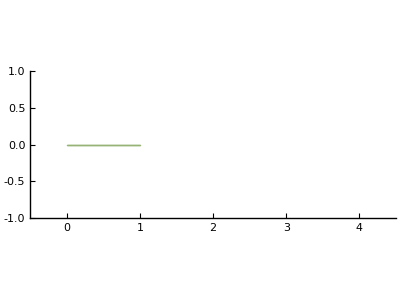

In [8]:
plot(body,xlim=xlim,ylim=ylim)

### Now set up the system

Set up the system and solver here

In [9]:
solver, sys, state0, f = initialize_ns_solver(Re,U∞,Δx,xlim,ylim,body)

(Order-3 IF-HERK integrator with
   State of type Nodes{Dual,504,208,Float64}
   Force of type VectorData{51,Float64}
   Time step size 0.005
, Navier-Stokes system on a grid of size 504 x 208, Dual nodes in a (nx = 504, ny = 208) cell grid of type Float64 data
  Number of Dual nodes: (nx = 504, ny = 208), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

### Advance the system

Set the time range to integrate over. To advance the flow past the flat plate to steady state, it is usually sufficient to run it to 5 convective times

In [10]:
tf = 5
T = sys.Δt:sys.Δt:tf

0.005:0.005:5.0

Initialize the state vector

In [11]:
t = 0.0
state0 .= 0.0
state = deepcopy(state0)
nothing

Initialize the storage of solution data

In [12]:
# integrated force components on the body
fx = Float64[]
fy = Float64[]
thist = Float64[]

# state vector data
tmin_store = 0.0
tmax_store = 100.0
tsample = 0.1
S = StorePlan(tmin_store,tmax_store,tsample,state,f,t,htype=RegularHistory)
data_history = initialize_storage(S)
nothing

Advance the solution. This will take a few minutes, usually.

In [13]:
@time for iter in eachindex(T)
    global t, state, f = solver(t,state)
    
    store_data!(data_history,t,S,deepcopy(state),deepcopy(f),t)
    
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    
end
println("solution completed through time t = ",t)

134.839764 seconds (6.02 M allocations: 48.661 GiB, 5.49% gc time)
solution completed through time t = 4.999999999999916


If you wish, you can save the current solution data in a file. This allows you to load it in and use it as an initial condition.

In [13]:
#save_ns_solution("FlatPlate0.jld",sys,body,state,f)

#### Plotting

In [83]:
iplot = length(data_history[1]) # index of time step for plotting
u, ω, ψ, Cp = get_flowfield(data_history[1][iplot],data_history[2][iplot],sys);
nothing

Plot the vorticity field

In [15]:
xg, yg = coordinates(state,sys.grid)

(-0.515:0.01:4.515, -1.035:0.01:1.035)

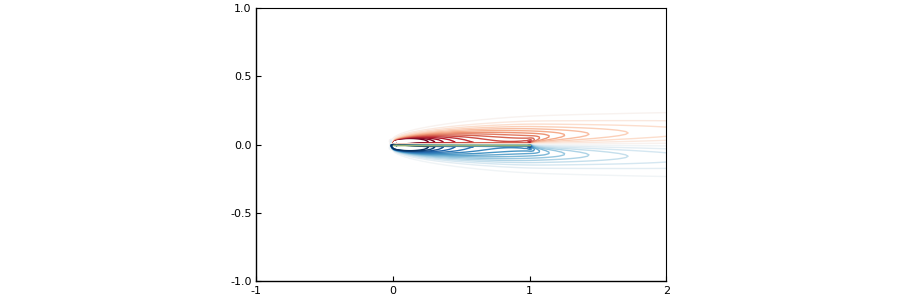

In [16]:
plot(xg,yg,ω,levels=range(-15,15,length=30), color = :RdBu,clim=(-15,15),ylim=(-1,1),xlim=(-1,4),size=(900,300))
plot!(body,xlim=(-1,2),ylim=(-1.0,1.0))

Plot the streamlines

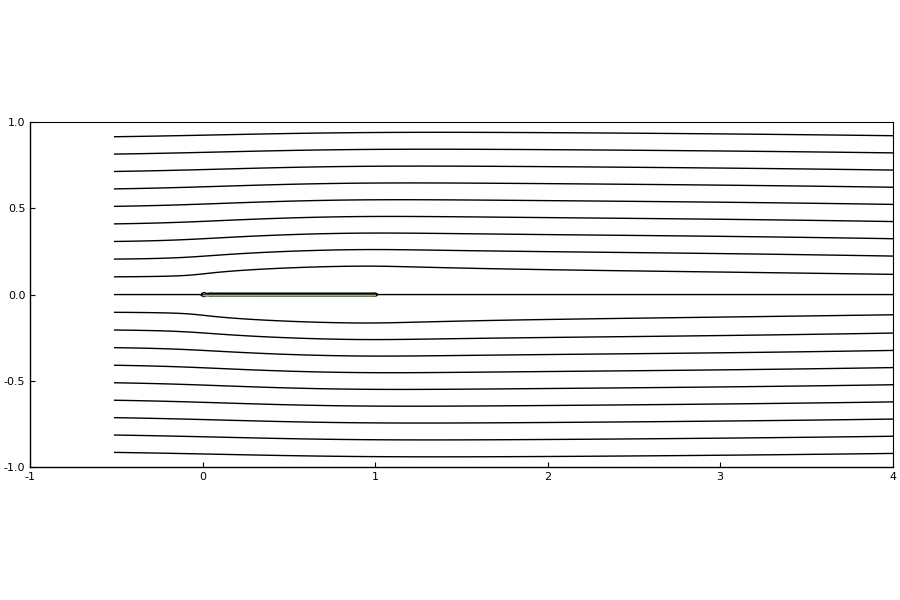

In [17]:
plot(xg,yg,ψ,levels=range(-1,2,length=31), color = :black, ylim = (-1,1),xlim = (-1,4),size=(900,600))
plot!(body)

### Plot lift and drag coefficient
The lift and drag coefficient are defined, respectively, as

$$ C_L = \dfrac{F_y}{\frac{1}{2} \rho U_\infty^2 L} $$

and

$$ C_D = \dfrac{F_x}{\frac{1}{2} \rho U_\infty^2 L} $$

But since we have already non-dimensionalized this problem, the forces we have computed are also dimensionless (they are already scaled by $\rho U_\infty^2 L$). This means we simply need to divide them by $1/2$, or equivalently, multiply them by 2:

In [18]:
CL = 2*fy
CD = 2*fx;

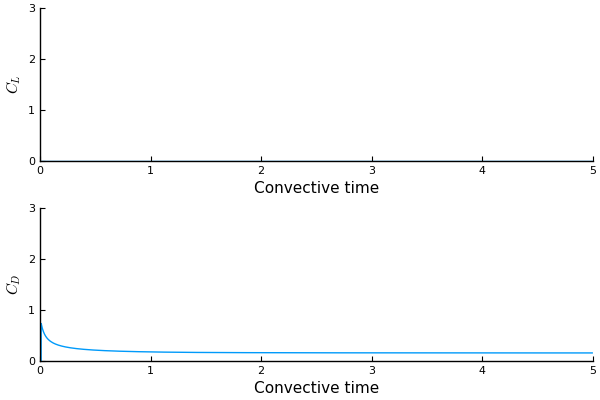

In [19]:
plt = plot(layout = (2,1), size = (600, 400))

plot!(plt[1],thist,CL,xlim=(0,5),ylim=(0,3),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot!(plt[2],thist,CD,xlim=(0,5),ylim=(0,3),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
plt

As we should expect, there is no lift on this plate (due to symmetry), and the drag reaches a steady-state value. What is the drag coefficient at the final time? We can think of this as the steady-state drag:

In [20]:
CD[end]

0.15147756441725357

**Homework problem**: Run this simulation at a few different Reynolds numbers (e.g., 200, 400, 500, 1000) and calculate the steady-state drag coefficient at each case. Make a plot of these values, $C_D$ vs $Re$, and also plot the expected values from the Blasius solution (making sure to account for the effect of both sides of the plate).

### Plot the velocity profile at different locations
Here, let us plot the velocity profile at different distances from the leading edge of the plate. In these plots, $x$ denotes distance from the leading edge.

In [21]:
xu,yu,xv,yv = coordinates(u,sys.grid)
ufcn, vfcn = interpolatable_field(xu,yu,xv,yv,u);

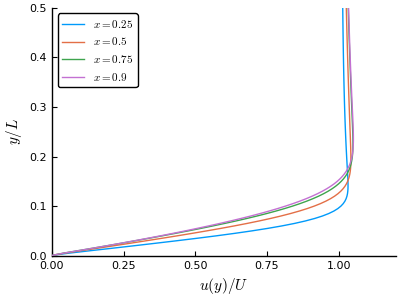

In [68]:
ysamp = range(0,0.5,length=101)
plot(ufcn.(0.25,ysamp.+Δx/2),ysamp,xlim=(0,1.2),ylim=(0,0.5),xlabel=L"u(y)/U",ylabel=L"y/L",label=L"x=0.25",legend=true)
plot!(ufcn.(0.5,ysamp.+Δx/2),ysamp,xlim=(0,1.2),ylim=(0,0.5),label=L"x=0.5")
plot!(ufcn.(0.75,ysamp.+Δx/2),ysamp,xlim=(0,1.2),ylim=(0,0.5),label=L"x=0.75")
plot!(ufcn.(0.9,ysamp.+Δx/2),ysamp,xlim=(0,1.2),ylim=(0,0.5),label=L"x=0.9")

These plots show the boundary layer's growth. As distance from the leading edge increases, the layer of slow-moving fluid gets **thicker**.

**Homework problem:** Plot the same velocity profiles as shown above, but rescale them so that they can be compared with the self-similar Blasius profile. Remember that the velocity is already scaled by the free stream speed, and this free stream speed is approximately equal to the external velocity $U_e$. So you can leave the velocity as it is. 

(a) The vertical coordinate $y$ is already scaled by the length of the plate. Show that you only need to divide this by $\sqrt{x/Re}$ to transform $y$ into the self-similar coordinate $\eta = y/\delta(x)$.

(b) Make the plot of $u/U$ vs $y/\delta(x)$ for the same four choices of $x$, taking care to evaluate $\delta$ at the corresponding $x$ location. **Include the Blasius profile itself on this plot.**

**Optional homework problem:** The results from the previous homework problem match with Blasius okay, but not great. The main reason for the mismatch is the slight variation of $U_e$ with $x$: the external velocity accelerates slightly over the boundary layer. In this problem, rescale the results as before, but take into account the local value of $U_e(x)$ in both $\delta(x)$ and in the scaled velocity $u/U_e(x)$. You can $U_e(x)$ from the original velocity profiles at each $x$, evaluating it at the edge of the boundary layer. Make the same plot, including the Blasius profile.

### Particle trajectories
As we know, particle trajectories in the steady-state flow are the same as streamlines. Let's look at the trajectory of a particle that starts just above the plane of the plate:

In [86]:
x0 = [-0.5,0.025] # initial location is in front of the plate, 0.025L above it
Tmax = 2.2
Δt = 0.001
sol = compute_trajectory(u,sys,x0,Tmax,Δt);

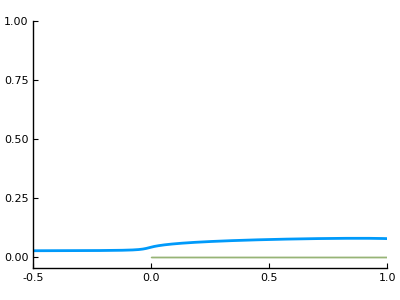

In [88]:
plot(sol[1,:],sol[2,:],linewidth=2,xlim=(-0.5,1),ylim=(-0.05,1))
plot!(body)

Notice that the streamline is deflected upward. This upward deflection is due to the slowed fluid in the boundary layer. The upward deflection of the streamline is the **displacement thickness**, $\delta^*(x)$. What is the displacement thickness at the end of the plate? Let's find it:

In [89]:
# this finds the index of the sol array where the x coordinate is equal to 0.5 (the end of the plate)
err, index = findmin(abs.(sol[1,:].-0.5))

# this evaluates the y coordinate of the streamline at x = 0.5 (minus the y coordinate it started with)
δstar = sol[2,index] - sol[2,1]

0.04760077134511973

**Homework problem**: Use the calculation of the $y$ displacement of the trajectory at the end of the plate relative to its original value to calculate the displacement thickness. Find this displacement thickness at the end of the plate for four different choices of Reynolds number (200, 400, 500, 1000). Plot the results ($\delta^*$ vs $Re$).